In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
from statsmodels.api import add_constant
from scipy import sparse
from sklearn import linear_model
from sklearn.linear_model import LassoCV
import math
import ipywidgets as widgets
from ipywidgets import interact
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit

import math

def round_to_sf(x, sig_figs):
    if x == 0:
        return 0
    return round(x, sig_figs - int(math.floor(math.log10(abs(x)))) - 1)

# Question Q1 Bass Noise-Robust Estimation
### 1. Estimate "M", "p" and "q" from the adoption series dataset using the linear regression approach described on Slides 8 and 9. From  these values, compute the values of N(t) beyond t=14. Specifically, compute N(30). No writeup necessary, simply state your values of "M", "p", "q" and N(30).

In [8]:
df = pd.read_excel('adoptionseries2_with_noise.xlsx')
df['A'] = df['N(t)'].cumsum().shift(fill_value=0)
df['A2'] = df['A'] ** 2

X = df[['A', 'A2']]
y = df['N(t)']
model1 = LinearRegression().fit(X, y)

a = model1.intercept_
b = model1.coef_[0]
c = model1.coef_[1]

p = round_to_sf((np.sqrt(b**2 - 4*a*c) - b) / 2, 3)
q = round_to_sf((np.sqrt(b**2 - 4*a*c) + b) / 2, 3)
M = round_to_sf(-q/c, 3)

print('M =', M)
print('p =', p)
print('q =', q)

M = 34.4
p = 0.00279
q = 0.214


In [10]:
for t in range(15,31):
   
    A = df.iloc[t-2]['A'] + df.iloc[t-2]['N(t)']
    A2 = A ** 2
    Nt = a + b * A + c * A2
    
    df1 = pd.DataFrame({'t': t, 
                        'N(t)': Nt, 
                        'A': A, 
                        'A2': A2}, 
                       index=[t-1])
    df = pd.concat([df, df1], ignore_index = True)
    
df.tail(16)

,t,N(t),A,A2
14,15,1.096503,5.687000,32.341969
15,16,1.243108,6.783503,46.015910
16,17,1.391215,8.026611,64.426477
17,18,1.534163,9.417826,88.695446
18,19,1.663869,10.951989,119.946057
19,20,1.771429,12.615858,159.159877
20,21,1.848074,14.387288,206.994046
21,22,1.886409,16.235362,263.586963
22,23,1.881700,18.121770,328.398555
23,24,1.832879,20.003470,400.138813


In [11]:
N30 = round_to_sf(df.iloc[29]['N(t)'], 3)
print('N(30) =', N30)

N(30) = 0.974


### 2. Assume M is fixed at M=100. Estimate "p" and "q" from the adoption series dataset from period 1 to 14 using the nonlinear regression approach, again based on the formula at the top of slide 8. See Question Q5 below for comments on what makes the model nonlinear when M is fixed, but linear when M is not fixed (as in Q1(1) above).   No writeup necessary, simply state your values of "p", "q" . 

In [4]:
df = pd.read_excel('adoptionseries2_with_noise.xlsx')
df['A'] = df['N(t)'].cumsum().shift(fill_value=0)
df['A2'] = df['A'] ** 2

M = 100

def reg(A, p, q):
    N = M*p + (q-p) * A - q/100 * A**2
    return N

X = df['A']
y = df['N(t)']

popt, pcov = curve_fit(reg, X, y)
p_hat = round_to_sf(popt[0], 3)
q_hat = round_to_sf(popt[1], 3)

print("p =", p_hat)
print("q =", q_hat)

p = 0.00106
q = 0.194


### 3. Using M=100 and the estimated values of "p" and "q" from Step 2 above, forecast into the future beyond period 14. Compute the value of N(30). No writeup necessary. Simply state the N(30) value that you got. 

In [6]:
df = pd.read_excel('adoptionseries2_with_noise.xlsx')
df['A'] = df['N(t)'].cumsum().shift(fill_value=0)
df['A2'] = df['A'] ** 2

M = 100
a = M * p_hat
b = q_hat - p_hat
c = -q_hat/M

for t in range(15,31):
   
    A = df.iloc[t-2]['A'] + df.iloc[t-2]['N(t)']
    A2 = A ** 2
    Nt = a + b * A + c * A2
    
    df1 = pd.DataFrame({'t': t, 
                        'N(t)': Nt, 
                        'A': A, 
                        'A2': A2}, 
                       index=[t-1])
    df = pd.concat([df, df1], ignore_index = True)
    
N30_new = round_to_sf(df.iloc[29]['N(t)'], 3)
print('N(30) =', N30_new)

N(30) = 4.9


### 4. Continue to assume M=100. Estimate "p" and "q" from the adoption series from period 1 to 14, this time using the Continuous Bass Model of  Slide 21.  You can do this via nonlinear regression in python creating a formula based on the expression at the bottom of Slide 21. [Alternatively you can set up an optimization calculation to minimize the Sum of Squared Errors(SSE), like on Slides 23-25, shown in the spreadsheet adoptionseries1_continuous_bass_solved.xls. In this spreadsheet if we start with p=0.001, q=0.5, M=100 (the values you see when you see when you open the spreadsheet), and run SOLVER to optimize for p,q,M, then we get estimates as p=0.000596, q=0.418653, M=123.4005.] For this HW question, because M is already assumed to be M=100, we optimize  for only p and q,  fixing M at 100. Use your estimated values of p and q to estimate the value of N(30) under the Continuous Bass Model. No writeup necessary. Simply state your values of p, q, and N(30). 

In [15]:
df = pd.read_excel('adoptionseries2_with_noise.xlsx')
df['A'] = df['N(t)'].cumsum().shift(fill_value=0)
df['A2'] = df['A'] ** 2

M = 100

def cont_bass(t, p, q):
    N = 100 * (1 - np.exp(-(p + q)*t))/(1 + q/p*np.exp(-(p + q)*t)) - 100 * (1 - np.exp(-(p + q)*(t-1)))/(1 + q/p*np.exp(-(p + q)*(t-1)))
    return N

X = df['t']
y = df['N(t)']

popt, pcov = curve_fit(cont_bass, X, y)
p_hat = round_to_sf(popt[0], 3)
q_hat = round_to_sf(popt[1], 3)

N30_new = round_to_sf(cont_bass(30, p_hat, q_hat), 3)

print("p =", p_hat)
print("q =", q_hat)
print('N(30) =', N30_new)

p = 0.000955
q = 0.179
N(30) = 4.51


# Question Q2 (Optional question for class participation credit)
### Consider M to be 100. Plot the N(t) curve as specified by the Bass Model for a broad range of value pairs for p and q, with p ranging from 0.005 to 0.08 and  q ranging from 0.1 to 0.8. Use the Discrete Bass model for this because it is simpler and leads to the same qualitative conclusions for this question as the Continuous Bass.  From these plots, make some summary observations on how the absolute and relative values of p and q influence different  aspects of the N(t) curve , like the shape, height, slope and decay duration. The motivation for this question is that if you know how p and q affect the shape of the curve, then this should allow you, by reverse-logic, to guess the value of p and q if you see the shape of the curve. Make sure you scale the plots the same way so that comparisons are easy to make. In your submitted response,  reproduce some of your plots to illustrate your summary observations. You will probably generate many plots to get an understanding of how p and q affect the N(t) curve. You definitely do not have to reproduce all of those plots in your submission, just enough to illustrate your summary observations.

### Details and suggestions on how to proceed: You need to do what we did on Slide 6 but for a larger set. Specifically, you consider different sets of values of p,q. For each set, you compute the true values N(1), N(2)...through N(Tmax) for some moderately large value of Tmax like 50, and inspect the curve. These are taken to be the true values from the Bass model. You do this for different values of p,q, then plot the curves and then recognize some general patterns.


In [31]:
def bassplot_fixM(p, q):
    
    df = pd.DataFrame({'t': range(1, 51), 'N(t)': 0, 'A': 0})
    
    M = 100
    
    for i in range(1, 50):
        df.loc[i, 'A'] = df.loc[i-1, 'A'] + df.loc[i-1, 'N(t)']
        df.loc[i, 'N(t)'] = M * p + (q - p) * df.loc[i, 'A'] - (q / M) * (df.loc[i, 'A'])**2
    
    plt.figure()
    
    plt.subplot(1, 2, 1)
    plt.plot(df['t'], df['N(t)'])
    plt.xlabel('periods')
    plt.ylabel('Adopters')
    plt.ylim(0, 50)
    plt.title('p={}, q={}'.format(p, q))
    
    plt.subplot(1, 2, 2)
    plt.plot(df['t'], df['A'])
    plt.xlabel('periods')
    plt.ylabel('Cumulative')
    plt.ylim(0, M)
    plt.title('p={}, q={}'.format(p, q))
    
    plt.tight_layout()
    plt.show()

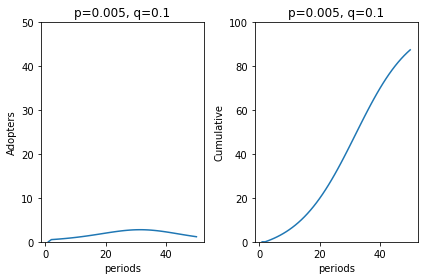

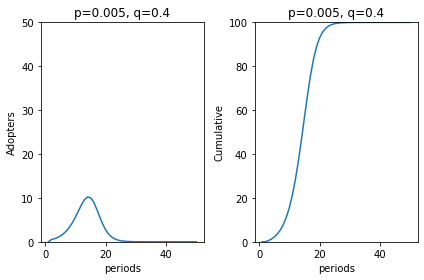

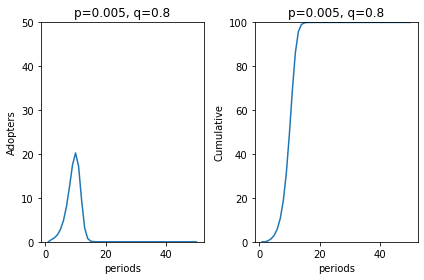

In [32]:
# constant small p, increasing q

bassplot_fixM(0.005, 0.1)
bassplot_fixM(0.005, 0.4)
bassplot_fixM(0.005, 0.8)

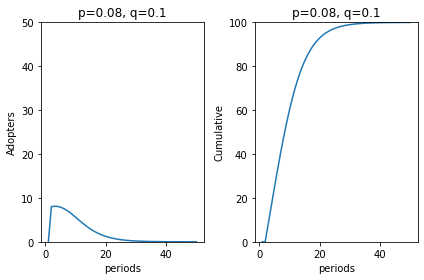

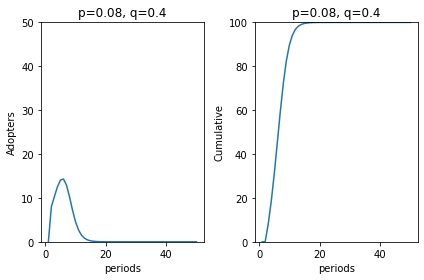

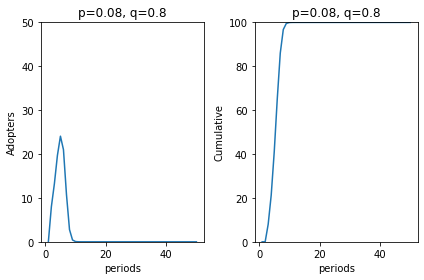

In [33]:
# constant large p, increasing q

bassplot_fixM(0.08, 0.1)
bassplot_fixM(0.08, 0.4)
bassplot_fixM(0.08, 0.8)

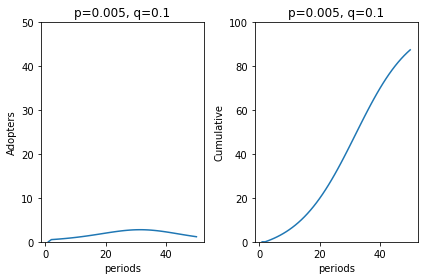

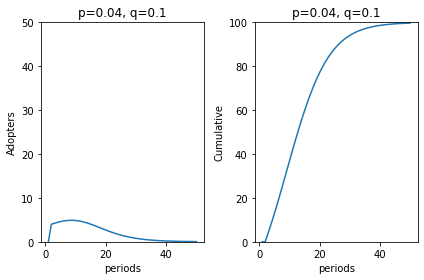

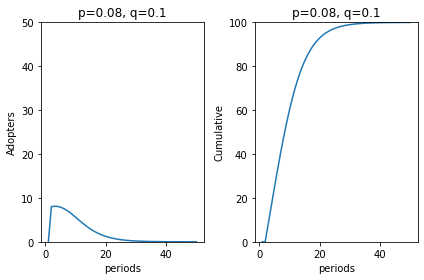

In [34]:
# increasing p, constant small q

bassplot_fixM(0.005, 0.1)
bassplot_fixM(0.04, 0.1)
bassplot_fixM(0.08, 0.1)

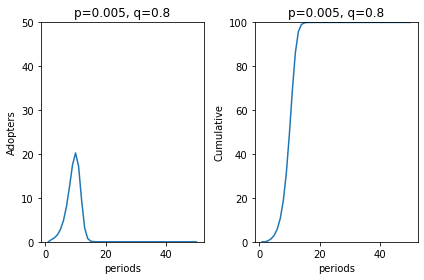

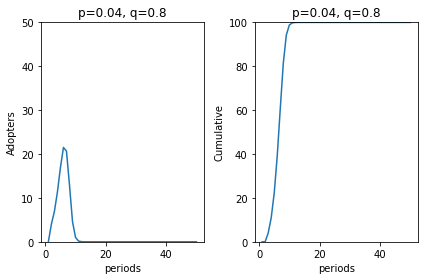

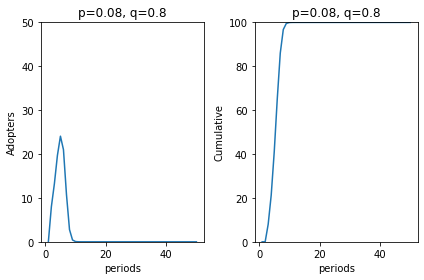

In [35]:
# increasing p, constant large q

bassplot_fixM(0.005, 0.8)
bassplot_fixM(0.04, 0.8)
bassplot_fixM(0.08, 0.8)

If p stays constant and as q increases, the shape of the Adopters curve remains concaved downward but becomes less flat, the height increases, the slope becomes steeper, and the decay duration decreases. The changes are similar between smaller and larger value of p.

If q stays constantly small and as p increases, the shape of the Adopters curve remains concaved downward but becomes slightly less flat, the height increases, the slope becomes steeper, and the decay duration increases.
If q stays constantly large and as p increases, the shape of the Adopters curve remains concaved downward but shifts to the left, the height slightly increases, and the slope and the decay duration remain relatively the same.

# Question Q3 (Optional question for class participation credit)
### Comparing Slides 12,13 with Slides 14,15, we see that the estimation error of M is larger  in the first case than in the second case, and consequently the forecasted curve beyond period 15 is much further from the true curve in the first case than in the second case.  What differences in the two time series or the nature of the noise (up to period 15) lead to the difference  described in the previous sentence. The main point of this question is not to tie you specifically to the examples on the slides but to make you think more broadly about the situations in the data or problem that lead to M being estimated poorly.  If you want, you can experiment with different values of p,q, different levels of noise and compare the forecasted curve with noise with the forecasted curve without noise as slides 14 and 16 do, or compute the magnitude of error in the estimated value of M.  This question is open ended, with a response ranging from 2 sentences to 3 pages. Points  will be accrued in proportion to the depth of analysis.

### Details and suggestions on how to proceed: You need to do what we did in slides 12 through 15 but for a larger set. Specifically, you consider different sets of values of p,q. For each set, you compute the true values N(1), N(2)...through N(Tmax) for some moderately large value of Tmax like 50, and inspect the curve. These are taken to be true values from the Bass model. So far this is the same as in the suggestions for Q2 above, but now the difference begins. We consider the situation like we typically encounter in real life, where we do not know the true values of p,q or the N() values,  we instead observe only N() values up to period 14, and that too only noisy or "shuffled" versions of these N() values. So we have to create modified values of the N() values by taking N(1), N(2), ... up to N(14) and adding some noise. This is what we did to go from the "original" column in Slide 12 or Slide 14 to the corresponding "shuffled" column. Then we assume that the "shuffled" data are the only dataset we have, and we  estimate p,q from this dataset. Then we extrapolate the shuffled data using the estimated p, q, and the shuffled N(14) and A(14) and the Bass Model recursive equations (Slide 4) to future periods to get estimates of the number of adopters in periods N(15), N(16),.. through N(TMax). Finally, we compare these to the true values of N(15), N(16),... N(TMax). This comparison is what we are doing in Slides 13 and 15. The extrapolated values based on the shuffled data are plotted as the dashed line, and the true values are plotted as the solid line.  Clearly, the extrapolation is more accurate in Slide 15 than in Slide 13. You need to try different sets of p, q, and recognized general patterns in when the extrapolation is more accurate and when it is less accurate. To make the analysis simpler I suggest you keep the level and type of noise to be fixed: so you would just add 10% noise to the data multiplying each true N with a uniform random number between 0.9 and 1.1.

# Question Q4 (Optional question for class participation credit)
### A model is a linear regression model when the number of predictors (including the constant column of 1s) is equal to the number of parameters to be estimated and there is a one-to-one mapping between the coefficients and the parameters to be estimated. If this condition fails to hold then it is a nonlinear regression. Linear regression does not necessarily mean that the plot between X and expected Y looks like a straight line.  In the equation N(t) = M*p + (q-p)*A(t) - (q/M)*A^2(t), if M is not fixed then there are three parameters (p,q,M) and three predictors including the intercept, and also there is a  one-to-one mapping, so this is a linear regression. In that same equation, if M is fixed then there are only two parameters and still three predictors, and so it becomes a nonlinear regression. Note, however, that in some cases, it is possible to modify the expression in a nonlinear regression situation to bring it to a linear regression situation, and indeed that modification is possible in the case of N(t) = M*p + (q-p)*A(t) - (q/M)*A^2(t) with M fixed as we do in Question Q1.2. What is that modification? Another way to ask this question: What are the predictors you will use in the post-modification linear regression? How do you get the values of p and q from the coefficients of this linear regression? Run the corresponding linear regression and verify that you get the same p and q values as in Question Q1.2. This question is about the discrete Bass and not continuous Bass.

In [16]:
df = pd.read_excel('adoptionseries2_with_noise.xlsx')
df['A'] = df['N(t)'].cumsum().shift(fill_value=0)
df['A2'] = df['A'] ** 2

M = 100

df['p_coef'] = M - df['A']
df['q_coef'] = df['A'] - (df['A2'] / M)

X = df[['p_coef', 'q_coef']]
y = df['N(t)']
model4 = LinearRegression(fit_intercept=False).fit(X, y)

p = round_to_sf(model4.coef_[0], 3)
q = round_to_sf(model4.coef_[1], 3)

print('p =', p)
print('q =', q)

p = 0.00106
q = 0.194


# Question Q5 on using generative AI tools to produce code (Optional question for class participation credit)
### For as many of the questions Q1 through Q4 above that you attempted, use a generative AI tool to produce python or R code. The code should be able to solve the HW problem exactly, it should not be code that solves some different, though related, problem. For each question, submit the following: (A) The prompt or sequence of prompts that you entered into the generative tool, (B) an identification of which sequence of prompts was entered into which  generative tool (like ChatGPT, Bing Chat, Bard, GitHub Copilot), (C) generative tool's  output from each prompt, identifying which output corresponds to which prompt and which generative tool.

#### Q1(A) 

extract results from LinearRegression

#### Q1(B) 
ChatGPT
#### Q1(C)

In [ ]:
# Extracting coefficients
coefficients = model.coef_
intercept = model.intercept_

#### Q2(A)
curve_fit

#### Q2(B)
ChatGpt

#### Q2(C)

In [ ]:
# Perform curve fitting
params, covariance = curve_fit(model_function, x_data, y_data, p0=initial_guess)